# Import

In [1]:
import os
import sys

import json
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import pytransform3d
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.plot_utils import make_3d_axis, plot_vector
from urdf_parser_py.urdf import URDF

# Helper Functions

In [2]:
%matplotlib widget

def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

def motor_cmd_joint(cmd_lnp,cmd_lnt,cmd_unt,cmd_et,cmd_lep,cmd_rep):  # degrees
    cmd_lnp = math.radians(cmd_lnp)
    cmd_lnt = math.radians(cmd_lnt)
    cmd_unt = math.radians(cmd_unt)
    cmd_et = math.radians(cmd_et)
    cmd_lep = math.radians(cmd_lep)
    cmd_rep = math.radians(cmd_rep)

    neck_pitch = cmd_lnt*0.5 + 0
    neck_yaw = cmd_lnp*0.5 + 0
    head_pitch = cmd_unt*0.5 + 0
    eyes_pitch = cmd_et*0.4 + 0
    lefteye_yaw = cmd_lep*1.6 + 0
    righteye_yaw = cmd_rep*1.7 + 0

    res_dict = {
        "neck_pitch": neck_pitch,
        "neck_yaw": neck_yaw,
        "head_pitch": head_pitch,
        "eyes_pitch": eyes_pitch,
        "lefteye_yaw": lefteye_yaw,
        "righteye_yaw": righteye_yaw,
    }

    return res_dict

def generate_chest_dataset(mat, z, x_prime, y_prime): # Opencv coordinates
    a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
    b = np.array([-mat[0,2]*z-mat[0,3], -mat[1,2]*z-mat[1,3], -mat[2,2]*z-mat[2,3]])
    x = np.linalg.solve(a, b)
    return np.append(x[:2],z)

# Initialization

In [3]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace_cam_true.urdf")
robot = URDF.from_xml_file(urdf_path)

In [4]:
# Load CSV Optimization Results

fit_result = "20241005_152748_279760_71552_075m_grace_results.csv"
data_dir = "thesis"
csv_path = os.path.join(os.getcwd(),"..","results",data_dir,fit_result)
csv_df = pd.read_csv(csv_path, index_col=0)
var_dict = dict(zip(csv_df.index,csv_df['learned'].values))

In [5]:
# Decision Variables 
var_list = list(var_dict.values())

# Variable Names
var_names_list = list(var_dict.keys())

# Mapping
idx2var = dict(zip(list(range(len(var_names_list))),var_names_list))
var2idx = dict(zip(var_names_list, list(range(len(var_names_list)))))

# Variable Assignment
V = np.array(var_list)

In [6]:
# URDF Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = V[var2idx['torso_origin_x']]
        joint.origin.position[1] = V[var2idx['torso_origin_y']]
        joint.origin.position[2] = V[var2idx['torso_origin_z']]
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = V[var2idx['neck_pitch_rot_r']]
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = V[var2idx['head_pitch_origin_z']]
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = V[var2idx['eyes_pitch_origin_x']]
        joint.origin.position[2] = V[var2idx['eyes_pitch_origin_z']]
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = V[var2idx['lefteye_yaw_origin_y']]
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = -V[var2idx['lefteye_yaw_origin_y']]
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = V[var2idx['lefteye_cam_origin_x']]
        joint.origin.rotation[0] = V[var2idx['lefteye_cam_rot_r']]
        joint.origin.rotation[2] = V[var2idx['lefteye_cam_rot_y']]
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = V[var2idx['righteye_cam_origin_x']]
        joint.origin.rotation[0] = V[var2idx['righteye_cam_rot_r']]
        joint.origin.rotation[2] = V[var2idx['righteye_cam_rot_y']]
        
# XML to String
urdf_str = xml_to_str(robot)

# Transform Manager
tm = UrdfTransformManager()
tm.load_urdf(urdf_str)

# Single Pass

In [7]:
# Input (rad)

cmd_lnt = 0
cmd_lnp = 0
cmd_unt = 0
cmd_et = 0
cmd_lep = 0
cmd_rep = 0

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

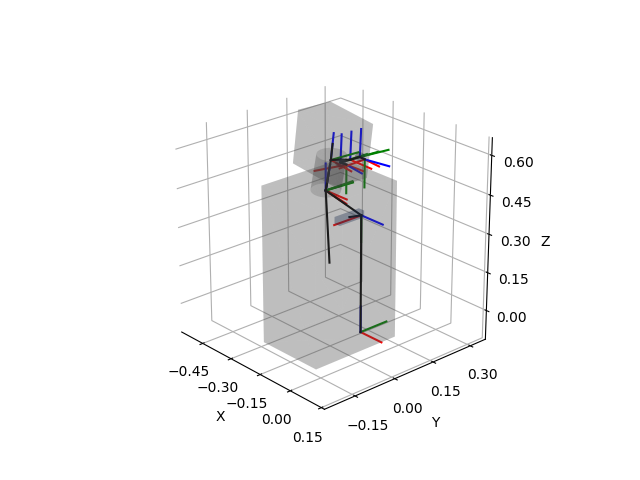

In [8]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
joints_list = ["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"]
ax = tm.plot_frames_in("world", whitelist=joints_list,
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.2)
ax.set_xlim([-0.55, 0.15])
ax.set_ylim([-0.25, 0.35])
ax.set_zlim([-0.1, 0.65])
ax.view_init(elev=24, azim=-42, roll=0)
plt.show()

# Camera Angle Rotation Offset

## Undistort Points

In [9]:
# Gaze Centers

left_gaze_pt_x = gaze_ctrs['left_eye']['x_center']
left_gaze_pt_y = gaze_ctrs['left_eye']['y_center']
right_gaze_pt_x = gaze_ctrs['right_eye']['x_center']
right_gaze_pt_y = gaze_ctrs['right_eye']['y_center']
print("left_gaze_pt_x:", left_gaze_pt_x)
print("left_gaze_pt_y:", left_gaze_pt_y)
print("right_gaze_pt_x:", right_gaze_pt_x)
print("right_gaze_pt_y:", right_gaze_pt_y)

left_gaze_pt_x: 411
left_gaze_pt_y: 235
right_gaze_pt_x: 151
right_gaze_pt_y: 246


In [10]:
# Normalized Point (z=1.0)
left_undistort_pts = cv2.undistortPoints((left_gaze_pt_x, left_gaze_pt_y), 
                                         np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                         np.array(cam_mtxs['left_eye']['distortion_coefficients']))
right_undistort_pts = cv2.undistortPoints((right_gaze_pt_x, right_gaze_pt_y), 
                                          np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                          np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('left_undistort_pts:', left_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System
print('right_undistort_pts:', right_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System

left_undistort_pts: [[[0.19142607 0.03459041]]]
right_undistort_pts: [[[-0.2600561   0.05559228]]]


In [11]:
# Undistored Points

left_x_prime = left_undistort_pts.squeeze()[0]
left_y_prime = left_undistort_pts.squeeze()[1]
right_x_prime = right_undistort_pts.squeeze()[0]
right_y_prime = right_undistort_pts.squeeze()[1]

print('left_x_prime:',left_x_prime)
print('left_y_prime:',left_y_prime)
print('right_x_prime:',right_x_prime)
print('right_y_prime:',right_y_prime)

left_x_prime: 0.19142607185001126
left_y_prime: 0.034590406011504184
right_x_prime: -0.26005610414060365
right_y_prime: 0.055592279312658976


In [12]:
# Checking of Undistortion
left_pixels,_ = cv2.projectPoints((left_undistort_pts.squeeze()[0], left_undistort_pts.squeeze()[1], 1.0), 
                                np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['left_eye']['distortion_coefficients']))
right_pixels,_ = cv2.projectPoints((right_undistort_pts.squeeze()[0], right_undistort_pts.squeeze()[1], 1.0), 
                                 np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('left_pixels:', left_pixels)
print('right_pixels:',right_pixels)

left_pixels: [[[411. 235.]]]
right_pixels: [[[151.00000002 246.        ]]]


## Orientation Offset Calculation

In [13]:
left_yaw_offset = math.atan2(left_undistort_pts.squeeze()[0],1.0)  # radians unit
left_pitch_offset = math.atan2(left_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System
right_yaw_offset = math.atan2(right_undistort_pts.squeeze()[0],1.0) 
right_pitch_offset = math.atan2(right_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System

print('left_yaw_offset(rad):', left_yaw_offset)
print('left_pitch_offset(rad)(opencv coord):', left_pitch_offset)
print('right_yaw_offset:(rad)', right_yaw_offset)
print('right_pitch_offset(rad)(opencv coord):', right_pitch_offset)
print('-----')

print('left_yaw_offset(deg):', math.degrees(left_yaw_offset))
print('left_pitch_offset(deg)(opencv coord):', math.degrees(left_pitch_offset))
print('right_yaw_offset(deg):', math.degrees(right_yaw_offset))
print('right_pitch_offset(deg)(opencv coord):', math.degrees(right_pitch_offset))

left_yaw_offset(rad): 0.18913797017088096
left_pitch_offset(rad)(opencv coord): 0.03457662014401592
right_yaw_offset:(rad) -0.2544206094843146
right_pitch_offset(rad)(opencv coord): 0.05553511593216458
-----
left_yaw_offset(deg): 10.836807436462736
left_pitch_offset(deg)(opencv coord): 1.981094404079137
right_yaw_offset(deg): -14.57722714459731
right_pitch_offset(deg)(opencv coord): 3.1819277576827667


# Plotting

## Left Basic Axes

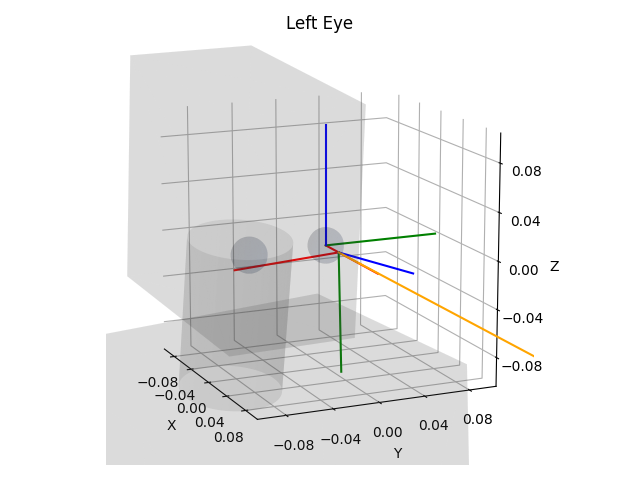

In [14]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("lefteye", whitelist=['lefteye','leftcamera'],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_visuals("lefteye", alpha=0.1)
T_lprimel = tm.get_transform('leftcamera','lefteye')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color="orange")
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_zlim([-0.1, 0.1])
ax.view_init(elev=14, azim=-24, roll=0)
ax.set_title('Left Eye')
plt.tight_layout()

## Basic Right Axes

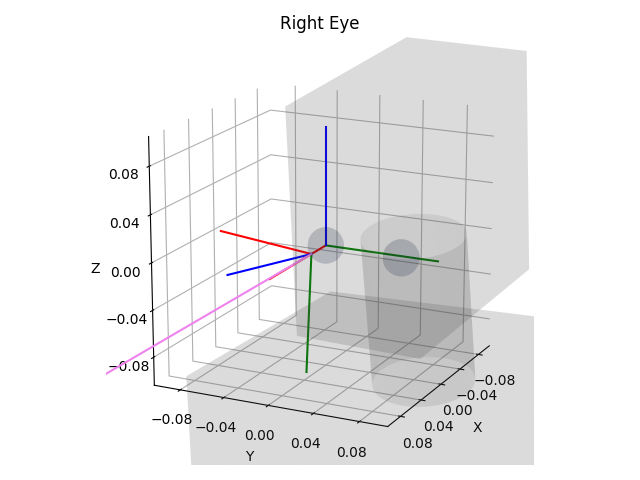

In [15]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("righteye", whitelist=['righteye','rightcamera'],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_visuals("righteye", alpha=0.1)
T_rprimer = tm.get_transform('rightcamera','righteye')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color="violet")
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_zlim([-0.1, 0.1])
ax.view_init(elev=17, azim=26, roll=0)
ax.set_title('Right Eye')
plt.tight_layout()

## Plot Left and Right Eye

In [16]:
# Input (rad)

cmd_lnt = 0
cmd_lnp = 0
cmd_unt = 0
cmd_et = 0
cmd_lep = math.radians(5)
cmd_rep = math.radians(5)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

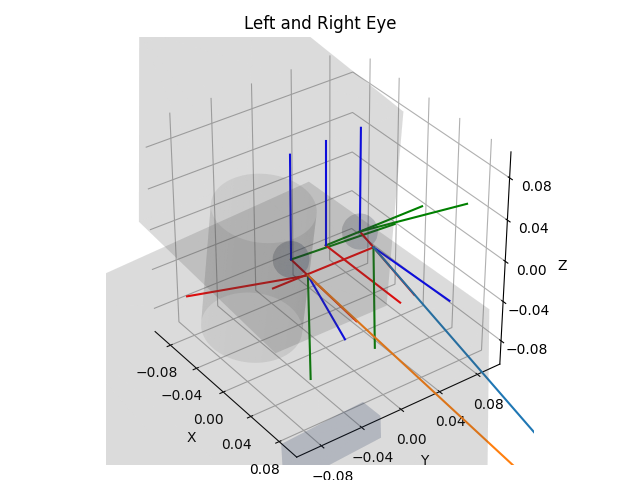

In [17]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('eyes', whitelist=['eyes','lefteye','leftcamera','righteye','rightcamera'],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_visuals("eyes", alpha=0.1)
T_lprimel = tm.get_transform('leftcamera', 'eyes')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'eyes')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]])
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]])
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_zlim([-0.1, 0.1])
ax.view_init(elev=34, azim=-36, roll=0)
ax.set_title('Left and Right Eye')
plt.tight_layout()

## Plot with Whole Robot

In [18]:
# Input (rad)

cmd_lnt = math.radians(5)
cmd_lnp = math.radians(5)
cmd_unt = math.radians(5)
cmd_et = math.radians(5)
cmd_lep = math.radians(5)
cmd_rep = math.radians(5)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

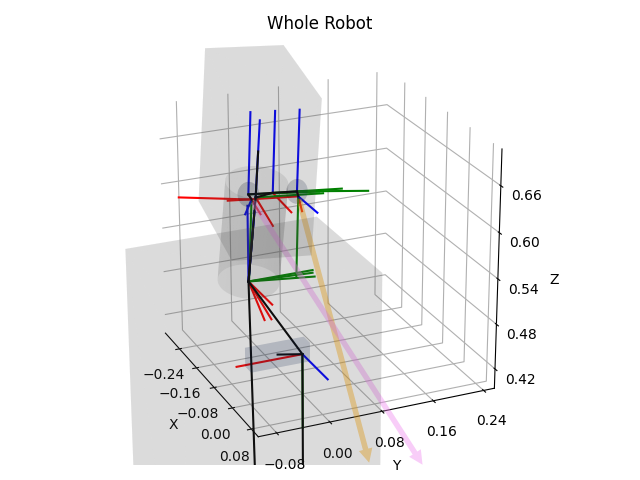

In [19]:
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()

# Left Gaze
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.0,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
# Right Gaze
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.0,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)

ax.view_init(elev=23, azim=-24, roll=0)
ax.set_xlim([-0.3, 0.1])
ax.set_ylim([-0.1, 0.25])
ax.set_zlim([0.4, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# Dataset Generation with Robot Gaze Plotting

In [36]:
# Input (rad)

cmd_lnt = math.radians(0)
cmd_lnp = math.radians(0)
cmd_unt = math.radians(0)
cmd_et = math.radians(0)
cmd_lep = math.radians(0)
cmd_rep = math.radians(0)

# Motor-to-Joint Mapping
neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt * V[var2idx['neck_pitch_polyfit_b1']]
neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp * V[var2idx['neck_yaw_polyfit_b1']]
head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt * V[var2idx['head_pitch_polyfit_b1']]
eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et * V[var2idx['eyes_pitch_polyfit_b1']]
lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep * V[var2idx['lefteye_yaw_polyfit_b1']]
righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep * V[var2idx['righteye_yaw_polyfit_b1']]

# Setting Motor Joints
tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

In [37]:
# Depth
z_depth = 1.0 # meters

# Get Transform
T_clprime = tm.get_transform('realsense','leftcamera')   # Opencv coords
T_crprime = tm.get_transform('realsense','rightcamera')   # Opencv coords

# Get Camera Chest Points
X_C_L = generate_chest_dataset(mat=T_clprime, z=z_depth, x_prime=left_x_prime, y_prime=left_y_prime)
X_C_R = generate_chest_dataset(mat=T_crprime, z=z_depth, x_prime=right_x_prime, y_prime=right_y_prime)
print('T_clprime:',T_clprime)
print('T_crprime:',T_crprime)
print('X_C_L:',X_C_L)
print('X_C_R:',X_C_R)

T_clprime: [[ 0.99415298 -0.04004038  0.10028273 -0.01202186]
 [ 0.03633676  0.99859807  0.03849066  0.21118227]
 [-0.10168333 -0.03462165  0.99421418 -0.02387733]
 [ 0.          0.          0.          1.        ]]
T_crprime: [[ 0.97577309 -0.03930102 -0.21522617 -0.07155881]
 [ 0.05406935  0.99653743  0.0631637   0.20942295]
 [ 0.21199854 -0.07327058  0.97451939 -0.04581674]
 [ 0.          0.          0.          1.        ]]
X_C_L: [ 0.08893505 -0.2196979   1.        ]
X_C_R: [ 0.03133818 -0.22214739  1.        ]


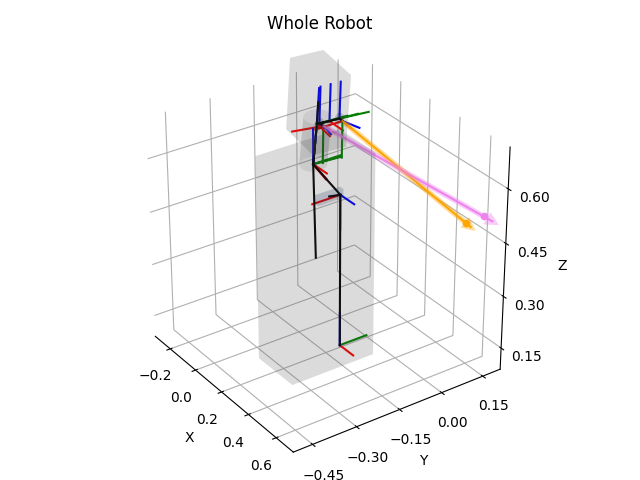

In [38]:
# Plotting

plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

#  Gaze Vectors
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
# Left Gaze
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color='orange')
# Right Gaze
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color='violet')

# Plot Points
T_cworld = tm.get_transform('realsense', 'world')
left_target_pts = (T_cworld @ np.array([X_C_L[0], X_C_L[1], X_C_L[2], 1.0]).reshape(-1,1)).squeeze()
right_target_pts = (T_cworld @ np.array([X_C_R[0], X_C_R[1], X_C_R[2], 1.0]).reshape(-1,1)).squeeze()
ax.scatter([left_target_pts[0]],[left_target_pts[1]],[left_target_pts[2]], color='orange')
ax.scatter([right_target_pts[0]],[right_target_pts[1]],[right_target_pts[2]], color='violet')

ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.5, 0.2])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# Inverse Kinematics

In [55]:
# Get Transform
T_cl = tm.get_transform('realsense','lefteye')   # Robot coords
T_cr = tm.get_transform('realsense','righteye')   # Robot coords
print("T_cl:",T_cl)
print("T_cr:",T_cr)

T_cl: [[ 8.99073962e-02 -3.61824011e-03  9.95943557e-01  8.00597221e-03]
 [-9.95136733e-01  4.00805513e-02  8.99801731e-02  8.83269758e-03]
 [-4.02435367e-02 -9.99189901e-01  2.89435664e-06 -2.11947940e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_cr: [[-3.50860630e-02  1.41602696e-03  9.99383291e-01  1.32135588e-02]
 [-9.98573696e-01  4.02186166e-02 -3.51146258e-02  7.73217829e-02]
 [-4.02435367e-02 -9.99189901e-01  2.89435664e-06 -2.11947940e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [56]:
x_cl = T_cl[:3,2]
x_cl

array([9.95943557e-01, 8.99801731e-02, 2.89435664e-06])

In [57]:
# Z for Plotting
T_lw = tm.get_transform('lefteye','world')
x_cl_p = (T_lw @ np.array([x_cl[0], x_cl[1], x_cl[2], 1.0]).reshape(-1,1)).squeeze()
x_cl_p 

array([9.91233130e-01, 4.55948010e-04, 6.59487652e-01, 1.00000000e+00])

In [61]:
# Z for Plotting
T_lw = tm.get_transform('lefteye','world')
x_cl_p = (T_lw @ np.array([1, 0, 0, 1.0]).reshape(-1,1)).squeeze()
x_cl_p 

array([ 0.98717637, -0.08945143,  0.66310591,  1.        ])

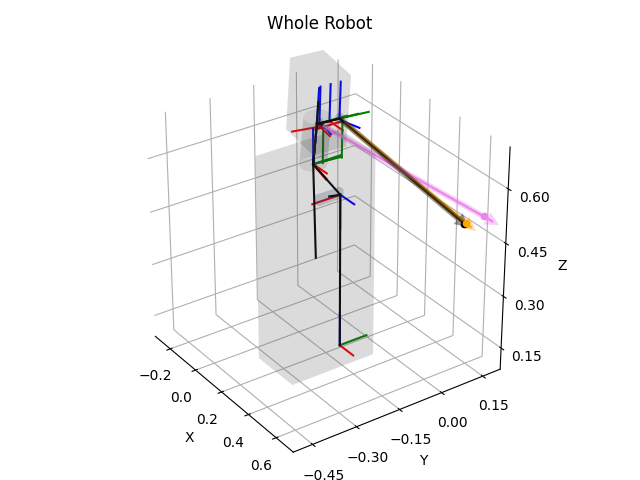

In [65]:
# Plotting

plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)
ax = tm.plot_visuals("world", alpha=0.1)

#  Gaze Vectors
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
# Left Gaze
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color='orange')
# Right Gaze
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color='violet')

# Plot Points
T_cworld = tm.get_transform('realsense', 'world')
left_target_pts = (T_cworld @ np.array([X_C_L[0], X_C_L[1], X_C_L[2], 1.0]).reshape(-1,1)).squeeze()
right_target_pts = (T_cworld @ np.array([X_C_R[0], X_C_R[1], X_C_R[2], 1.0]).reshape(-1,1)).squeeze()
ax.scatter([left_target_pts[0]],[left_target_pts[1]],[left_target_pts[2]], color='orange')
ax.scatter([right_target_pts[0]],[right_target_pts[1]],[right_target_pts[2]], color='violet')


# Real One
T_lw = tm.get_transform('lefteye', 'world')
ax.scatter([x_cl_p[0]],[x_cl_p[1]],[x_cl_p[2]], color='black')
plot_vector(
    start=np.array([T_lw[0,3], T_lw[1,3], T_lw[2,3]]),
    direction=np.array([x_cl_p[0]-T_lw[0,3], x_cl_p[1]-T_lw[1,3], x_cl_p[2]-T_lw[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='black',
    alpha=0.4
)
ax.plot([T_lw[0,3],x_cl_p[0]],[T_lw[1,3],x_cl_p[1]],[T_lw[2,3],x_cl_p[2]], color='black')

ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.5, 0.2])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

# New Pixel

In [71]:
l_theta_r =  V[var2idx['lefteye_cam_rot_r']] + math.pi/2
l_theta_y =  V[var2idx['lefteye_cam_rot_y']] + math.pi/2
r_theta_r =  V[var2idx['righteye_cam_rot_r']] + math.pi/2
r_theta_y =  V[var2idx['righteye_cam_rot_y']] + math.pi/2

print("l_theta_r:", l_theta_r)
print("l_theta_y:", l_theta_y)
print("r_theta_r:", r_theta_r)
print("r_theta_y:", r_theta_y)

print('-----')

print('left_pitch_offset(rad)(opencv coord):', left_pitch_offset)
print('left_yaw_offset(rad):', left_yaw_offset)
print('right_pitch_offset(rad)(opencv coord):', right_pitch_offset)
print('right_yaw_offset:(rad)', right_yaw_offset)

l_theta_r: 0.03869824008382294
l_theta_y: 0.19055362100197382
r_theta_r: 0.06472766343170466
r_theta_y: -0.25204527016734346
-----
left_pitch_offset(rad)(opencv coord): 0.03457662014401592
left_yaw_offset(rad): 0.18913797017088096
right_pitch_offset(rad)(opencv coord): 0.05553511593216458
right_yaw_offset:(rad) -0.2544206094843146


In [73]:
new_left_x_prime = math.tan(l_theta_y)
new_left_y_prime = math.tan(l_theta_r)
new_right_x_prime = math.tan(r_theta_y)
new_right_y_prime = math.tan(r_theta_r)

print('new_left_x_prime:',new_left_x_prime)
print('new_left_y_prime:',new_left_y_prime)
print('new_right_x_prime:',new_right_x_prime)
print('new_right_y_prime:',new_right_y_prime)


print('-----')

print('left_x_prime:',left_x_prime)
print('left_y_prime:',left_y_prime)
print('right_x_prime:',right_x_prime)
print('right_y_prime:',right_y_prime)

new_left_x_prime: 0.1928939964837528
new_left_y_prime: 0.038717569227789614
new_right_x_prime: -0.2575216833793788
new_right_y_prime: 0.06481821103938706
-----
left_x_prime: 0.19142607185001126
left_y_prime: 0.034590406011504184
right_x_prime: -0.26005610414060365
right_y_prime: 0.055592279312658976


In [74]:
# Checking of Undistortion
new_left_pixels,_ = cv2.projectPoints((new_left_x_prime, new_left_y_prime, 1.0), 
                                np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['left_eye']['distortion_coefficients']))
new_right_pixels,_ = cv2.projectPoints((new_right_x_prime, new_right_y_prime, 1.0), 
                                 np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['right_eye']['distortion_coefficients']))

print('new_left_pixels:', new_left_pixels)
print('new_right_pixels:',new_right_pixels)

print('-----')

print('left_pixels:', left_pixels)
print('right_pixels:',right_pixels)

new_left_pixels: [[[411.83620817 237.33684899]]]
new_right_pixels: [[[152.49851915 251.32199021]]]
-----
left_pixels: [[[411. 235.]]]
right_pixels: [[[151.00000002 246.        ]]]
